In [10]:
! git clone https://github.com/emanhamed/Houses-dataset.git

fatal: destination path 'Houses-dataset' already exists and is not an empty directory.


In [2]:
import os
import glob
import locale
import argparse
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Activation
from tensorflow.keras.layers import MaxPooling2D, Conv2D, BatchNormalization
from sklearn.model_selection import train_test_split

In [3]:
def load_house_attributes(inputPath):
	# initialize the list of column names in the CSV file and then
	# load it using Pandas
	cols = ["bedrooms", "bathrooms", "area", "zipcode", "price"]
	df = pd.read_csv(inputPath, sep=" ", header=None, names=cols)
	# determine (1) the unique zip codes and (2) the number of data
	# points with each zip code
	zipcodes = df["zipcode"].value_counts().keys().tolist()
	counts = df["zipcode"].value_counts().tolist()
	# loop over each of the unique zip codes and their corresponding
	# count
	for (zipcode, count) in zip(zipcodes, counts):
		# the zip code counts for our housing dataset is *extremely*
		# unbalanced (some only having 1 or 2 houses per zip code)
		# so let's sanitize our data by removing any houses with less
		# than 25 houses per zip code
		if count < 25:
			idxs = df[df["zipcode"] == zipcode].index
			df.drop(idxs, inplace=True)
	# return the data frame
	return df

In [13]:
def load_house_images(df, inputPath):
	# initialize our images array (i.e., the house images themselves)
	images = []
	# loop over the indexes of the houses
	for i in df.index.values:
		# find the four images for the house and sort the file paths,
		# ensuring the four are always in the *same order*
		basePath = os.path.sep.join([inputPath, "{}_*".format(i + 1)])
		housePaths = sorted(list(glob.glob(basePath)))
		# initialize our list of input images along with the output image
		# after *combining* the four input images
		inputImages = []
		outputImage = np.zeros((64, 64, 3), dtype="uint8")
		# loop over the input house paths
		for housePath in housePaths:
			# load the input image, resize it to be 32 32, and then
			# update the list of input images
			image = cv2.imread(housePath)
			image = cv2.resize(image, (32, 32))
			inputImages.append(image)
		# tile the four input images in the output image such the first
		# image goes in the top-right corner, the second image in the
		# top-left corner, the third image in the bottom-right corner,
		# and the final image in the bottom-left corner
		outputImage[0:32, 0:32] = inputImages[0]
		outputImage[0:32, 32:64] = inputImages[1]
		outputImage[32:64, 32:64] = inputImages[2]
		outputImage[32:64, 0:32] = inputImages[3]
		# add the tiled image to our set of images the network will be
		# trained on
		images.append(outputImage)
	# return our set of images
	return np.array(images)

In [5]:
def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
	# initialize the input shape and channel dimension, assuming
	# TensorFlow/channels-last ordering
	inputShape = (height, width, depth)
	chanDim = -1
	# define the model input
	inputs = Input(shape=inputShape)
	# loop over the number of filters
	for (i, f) in enumerate(filters):
		# if this is the first CONV layer then set the input
		# appropriately
		if i == 0:
			x = inputs
		# CONV => RELU => BN => POOL
		x = Conv2D(f, (3, 3), padding="same")(x)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = MaxPooling2D(pool_size=(2, 2))(x)
	# flatten the volume, then FC => RELU => BN => DROPOUT
	x = Flatten()(x)
	x = Dense(16)(x)
	x = Activation("relu")(x)
	x = BatchNormalization(axis=chanDim)(x)
	x = Dropout(0.5)(x)
	# apply another FC layer, this one to match the number of nodes
	# coming out of the MLP
	x = Dense(4)(x)
	x = Activation("relu")(x)
	# check to see if the regression node should be added
	if regress:
		x = Dense(1, activation="linear")(x)
	# construct the CNN
	model = Model(inputs, x)
	# return the CNN
	return model

In [6]:
# # construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-d", "--dataset", type=str, required=True,
# 	help="path to input dataset of house images")
# args = vars(ap.parse_args())

In [7]:
# construct the path to the input .txt file that contains information
# on each house in the dataset and then load the dataset
print("[INFO] loading house attributes...")
inputPath = os.path.sep.join(['Houses-dataset/Houses Dataset', "HousesInfo.txt"])
df = load_house_attributes(inputPath)
# load the house images and then scale the pixel intensities to the
# range [0, 1]
print("[INFO] loading house images...")
images = load_house_images(df, 'Houses-dataset/Houses Dataset')
scaled_images = images / 255.0
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
split = train_test_split(df, scaled_images, test_size=0.25, random_state=42)
(trainAttrX, testAttrX, trainImagesX, testImagesX) = split

[INFO] loading house attributes...
[INFO] loading house images...


In [8]:
# find the largest house price in the training set and use it to
# scale our house prices to the range [0, 1] (will lead to better
# training and convergence)
maxPrice = trainAttrX["price"].max()
trainY = trainAttrX["price"] / maxPrice
testY = testAttrX["price"] / maxPrice
# create our Convolutional Neural Network and then compile the model
# using mean absolute percentage error as our loss, implying that we
# seek to minimize the absolute percentage difference between our
# price *predictions* and the *actual prices*
model = create_cnn(64, 64, 3, regress=True)
opt = Adam(learning_rate=1e-3, weight_decay=1e-3 / 200, )
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)
# train the model
print("[INFO] training model...")
model.fit(x=trainImagesX, y=trainY,
    validation_data=(testImagesX, testY),
    epochs=200, batch_size=8)

[INFO] training model...
Epoch 1/200
34/34 [==============================] - 3s 33ms/step - loss: 1690.6016 - val_loss: 2877.4180
Epoch 2/200
34/34 [==============================] - 1s 28ms/step - loss: 1122.5781 - val_loss: 5179.9214
Epoch 3/200
34/34 [==============================] - 1s 28ms/step - loss: 812.8103 - val_loss: 7179.0962
Epoch 4/200
34/34 [==============================] - 1s 27ms/step - loss: 577.6769 - val_loss: 8198.0957
Epoch 5/200
34/34 [==============================] - 1s 28ms/step - loss: 477.9572 - val_loss: 9474.4229
Epoch 6/200
34/34 [==============================] - 1s 28ms/step - loss: 372.5439 - val_loss: 8524.5713
Epoch 7/200
34/34 [==============================] - 1s 41ms/step - loss: 368.9793 - val_loss: 6783.5459
Epoch 8/200
34/34 [==============================] - 1s 29ms/step - loss: 339.0488 - val_loss: 4615.7495
Epoch 9/200
34/34 [==============================] - 1s 28ms/step - loss: 239.7331 - val_loss: 3222.7417
Epoch 10/200
34/34 [========

In [9]:
# make predictions on the testing data
print("[INFO] predicting house prices...")
preds = model.predict(testImagesX)
# compute the difference between the *predicted* house prices and the
# *actual* house prices, then compute the percentage difference and
# the absolute percentage difference
diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)
# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. house price: {}, std house price: {}".format(
	locale.currency(df["price"].mean(), grouping=True),
	locale.currency(df["price"].std(), grouping=True)))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] predicting house prices...
3/3 [==============================] - 0s 24ms/step
[INFO] avg. house price: $533,388.27, std house price: $493,403.08
[INFO] mean: 54.82%, std: 45.12%


In [29]:
for path in os.listdir('test'):
  print(path)

324_bathroom.jpg
324_frontal.jpg
324_bedroom.jpg
324_kitchen.jpg


In [81]:
def inference(inputPath):
  images = []

  housePathes = []

  for path in os.listdir(inputPath):
    housePathes.append(f'{inputPath}/{path}')

  housePathes.sort()
  inputImages = []
  orginalImages = []
  outputImage = np.zeros((64, 64, 3), dtype="uint8")
  showingImage = np.zeros((320, 320, 3), dtype="uint8")

  for housePath in housePathes:
    image = cv2.imread(housePath)
    resized_image = cv2.resize(image, (32, 32))
    image = cv2.resize(image, (160, 160))
    inputImages.append(resized_image)
    orginalImages.append(image)

  outputImage[0:32, 0:32] = inputImages[0]
  outputImage[0:32, 32:64] = inputImages[1]
  outputImage[32:64, 32:64] = inputImages[2]
  outputImage[32:64, 0:32] = inputImages[3]

  showingImage[0:160, 0:160] = orginalImages[0]
  showingImage[0:160, 160:320] = orginalImages[1]
  showingImage[160:320, 160:320] = orginalImages[2]
  showingImage[160:320, 0:160] = orginalImages[3]

  outputImage = outputImage.reshape(1, 64, 64, 3)

  output = model.predict(outputImage)
  maxPrice = trainAttrX["price"].max()
  price = output * maxPrice

  plt.imshow(showingImage)
  plt.title(f'Predicted Price : ${int(price)}')

1/1 [==============================] - 0s 15ms/step


<ipython-input-81-ee39d56c661f>:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f'Predicted Price : ${int(price)}')


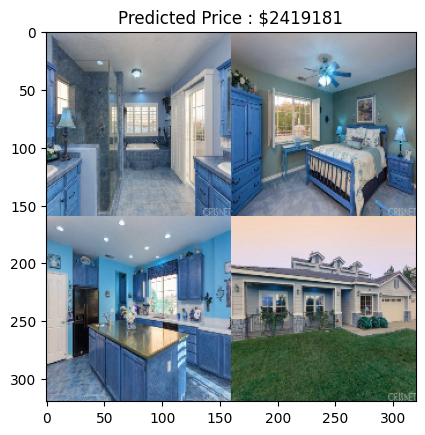

In [82]:
inference('test')